## learning-AI : AI-101
### assignment : iris classification (ML)

**iris 데이터를 SVM, random forest, decision tree, logistic regression, KNN 기법을 적용하여 classification**

<br>

- **임규연 (lky473736)**
- 2025.03.05.에 문서 작성
- **dataset** : iris dataset
- **data abstract** : A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.


------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

-------

### 1. 데이터 EDA (탐색적 데이터 분석)

classification을 진행하기 전, 데이터 구조를 파악한다.

- **데이터 구조 파악 및 EDA**
    - 각 feature가 의미하는 바를 분석, 결측치 파악 후 어떻게 classification을 진행하는 것이 탁월할 지 파악
    - 각 feature에 대한 사분위수, mean, max, min, median, corr
    - seaborn을 통한 corr 상관관계 및 histplot 시각화
    - 각 feature에 대한 box plot 시각화
    - target의 도수를 bar plot 시각화

#### 1-1) 파일 열기, 기초 통계량 분석 및 classifiaction 전략 도출

In [3]:
# pandas를 이용하여 데이터프레임 불러오기

df = pd.read_csv ('../data/iris.csv')
df.head()   

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


각 attribute가 의미하는 바는 아래와 같다.

- SepalLength (꽃받침 길이, cm): 붓꽃의 꽃받침(꽃을 감싸고 있는 구조물)의 길이를 나타냄.
- SepalWidth (꽃받침 너비, cm): 꽃받침의 너비를 나타냄.
- PetalLength (꽃잎 길이, cm): 붓꽃의 꽃잎(화판) 길이를 나타냄.
- PetalWidth (꽃잎 너비, cm): 꽃잎의 너비를 나타냄.
- Name (품종): 붓꽃의 품종을 나타냄. (예: Iris-setosa, Iris-versicolor, Iris-virginica)

이때 Name column이 target이 되고, 나머지를 feature로 구성한다. 각 특성을 조합하여 모델을 구성하고, 입력 데이터에 따른 iris의 품종을 classification할 것이다. 하지만 우려되는 건, 만약 setosa, versicolor, virginica 중 특이한 품종이 있다면 그 품종에 대한 개체 수가 적어 클래스 편향이 발생하여 학습이 원활히 진행되지 않을 수 있다. 따라서 countplot을 그려서 각각의 품종의 도수를 확인해보자.

In [18]:
# df에서의 결측치 및 정보 확인

print (df.info())
print (df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SepalLength  150 non-null    float64
 1   SepalWidth   150 non-null    float64
 2   PetalLength  150 non-null    float64
 3   PetalWidth   150 non-null    float64
 4   Name         150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB
None
SepalLength    0
SepalWidth     0
PetalLength    0
PetalWidth     0
Name           0
dtype: int64


In [4]:
# df의 행의 갯수, 열의 갯수, feature 파악

df.shape, df.columns

((150, 5),
 Index(['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Name'], dtype='object'))

In [6]:
# df의 기본적인 통계량 수치 파악, 각 열마다의 데이터 타입 

for col in df.columns : 
    print (col, ':', df[col].dtype)
    
df.describe()

SepalLength : float64
SepalWidth : float64
PetalLength : float64
PetalWidth : float64
Name : object


,SepalLength,SepalWidth,PetalLength,PetalWidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


classification 전략을 세우자면 아래와 같다.

- **classification 전략**
    - 학습 전에 데이터를 아래와 같이 준비
        - 특성 변수 (feature) : SepalLength, SepalWidth, PetalLength, PetalWidth
        - 타겟 변수 (target) : Name
    - SVM, logistic regression 전에 스케일링 필요
    - 또한, Name 열이 현재 문자열로 이루어져 있어서 추후 label encoding을 거치는 것이 좋겠음
    
-------

#### 1-2) seaborn을 통한 countplot, 상관관계 heatmap 및 전체 histplot 시각화
- 시각화 전, Name 열을 먼저 encoding한다.

In [7]:
# name 열 encoding (label)

from sklearn.preprocessing import LabelEncoder

print (df['Name'].value_counts())

LE = LabelEncoder()
df['Name'] = LE.fit_transform(df['Name'])

print (df['Name'].value_counts())

Name
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64
Name
0    50
1    50
2    50
Name: count, dtype: int64


<Axes: xlabel='Name', ylabel='count'>

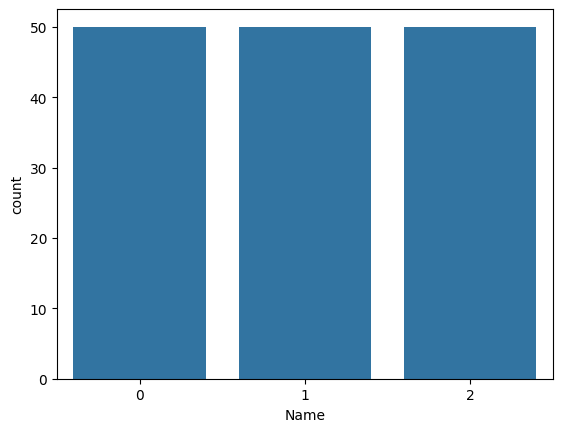

In [14]:
# countplot of Name 열

sns.countplot(data=df, x=df['Name'])

위 countplot을 보고, 아래와 같은 사실을 확인할 수 있다.

- 모든 label의 빈도 수가 50으로 동일하다. 그러니 추후에 train_test_split 사용 시에 stratify 파라미터를 False로 해도 문제 없다. (과연?)
- 각각의 데이터는 각 iris의 품종에 매우 균일하게 얻어지었다.

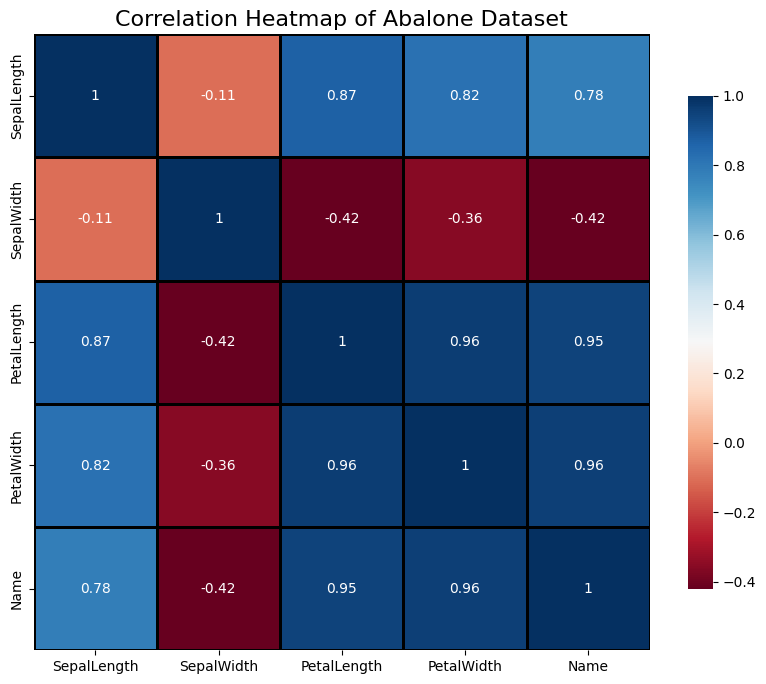

In [11]:
# seaborn을 통하여 heatmap 시각화
# 상관계수 행렬, 각 변수 간의 선형적 관계를 시각적으로 표시

correlation_matrix = df.corr() # feature
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Abalone Dataset', fontsize=16)
plt.show()

위 heatmap는 음수로 갈 수록 음의 상관관계(반비례), 양수로 갈 수록 양의 상관관계(정비례)를 의미한다. 또한 diagonal을 중심으로 각 part가 대칭이다. (symmetric) figure를 보고 주목해야 할 부분은 아래와 같이 분석할 수 있다.

- **높은 상관관계**
     - PetalLength : 꽃잎 길이와 Name
     - SepalLength : 꽃받침 길이와 Name
     - PetalWidth : 꽃잎 너비와 Name
- **낮은 상관관계**  
    - SepalWidth
        - Name와 SepalWidth (꽃받침 너비)는 상관관계가 음수를 띈다. 이를 통해서 Name을 구분하기 위해 SepalWidth라는 feature은 그리 중요한 feature가 아닐 수 있음을 확인 가능하다.

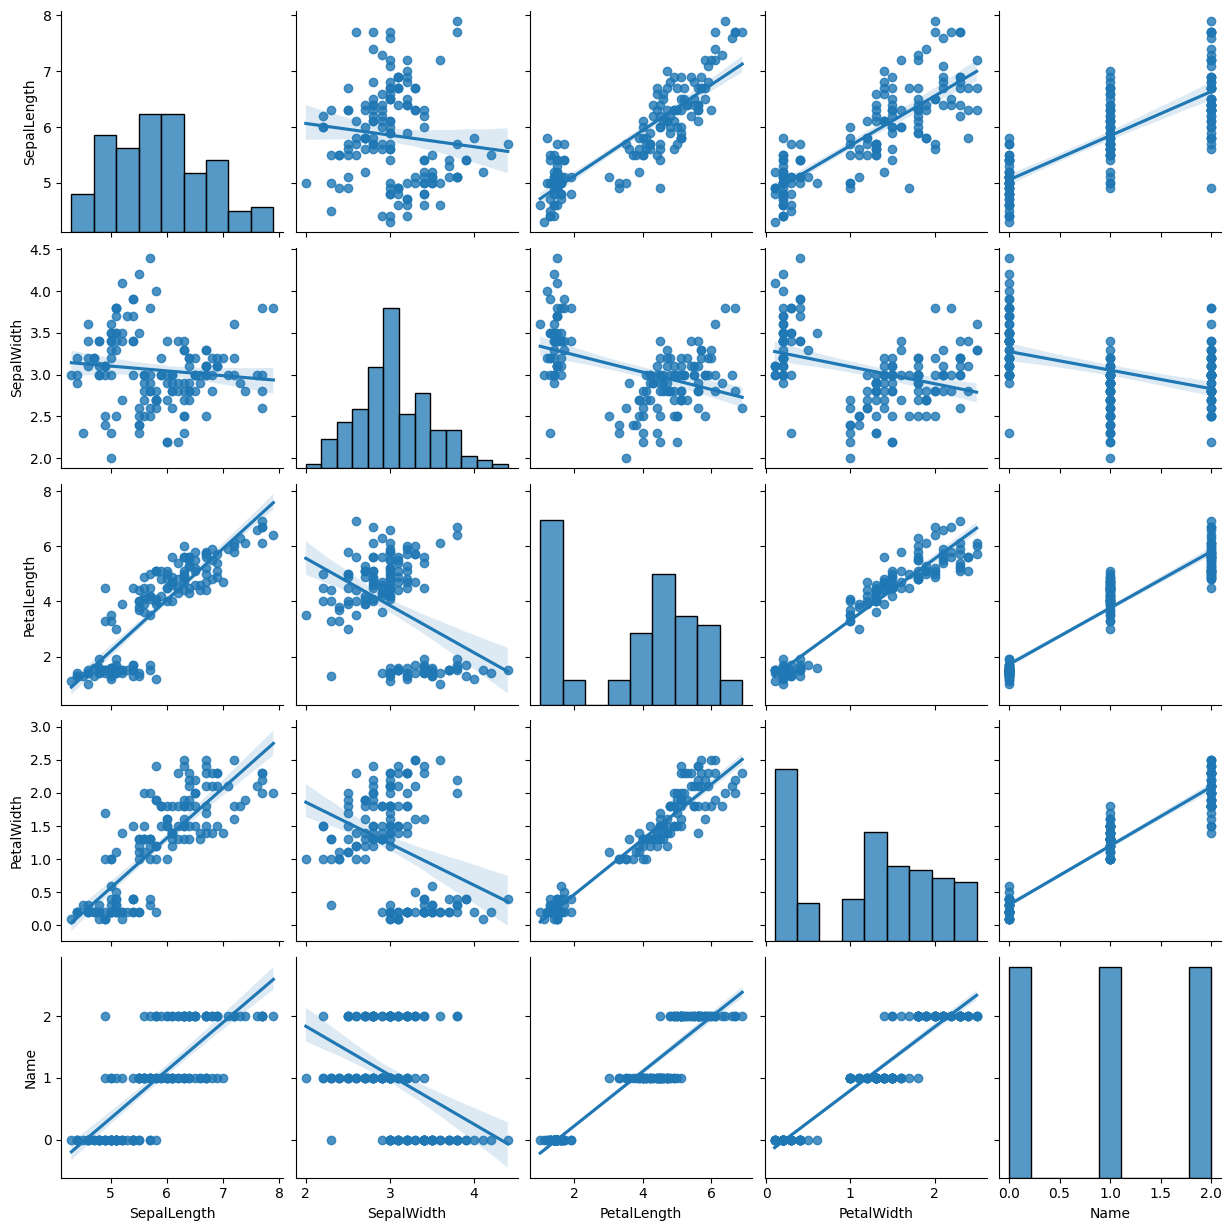

In [15]:
# seaborn을 통하여 pairplot 시각화
# 현재 데이터프레임의 모든 열 쌍에 대한 산점도와 히스토그램을 시각화한다

sns.pairplot(df, kind="reg")
plt.show()

------

#### 1-3) 각 feature에 대한 box plot 시각화



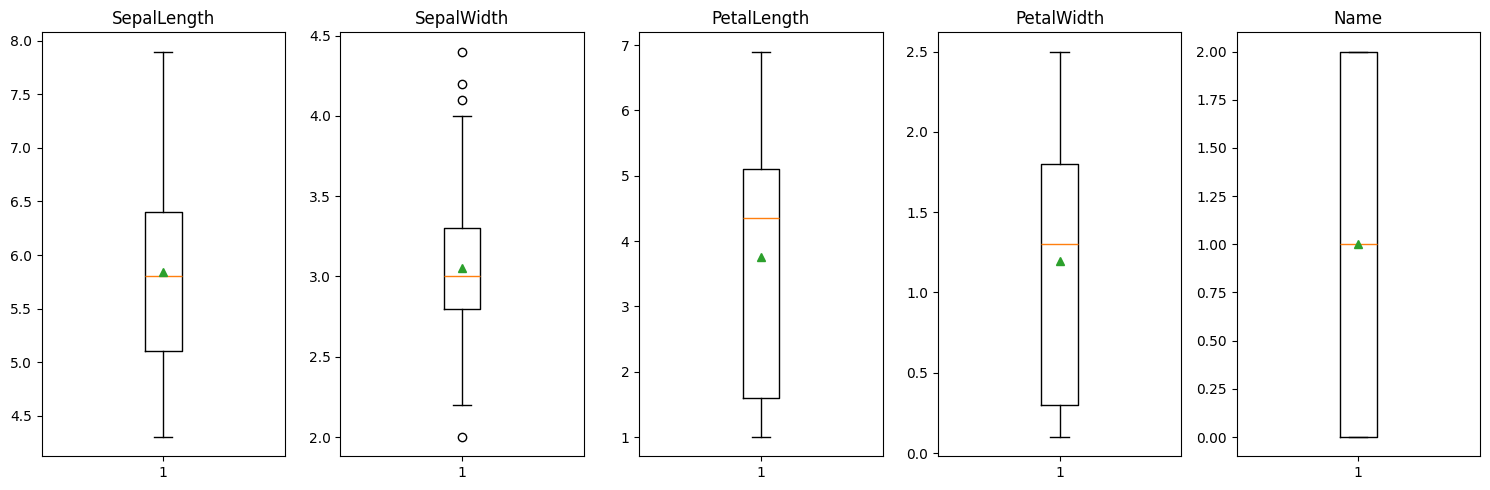

In [17]:
# box plot 그려 데이터 분포 확인

attr_list = df.columns

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=len(attr_list), figsize=(15, 5))

# 각 변수에 대한 boxplot 그리기
for i, var in enumerate(attr_list) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

위를 확인하였을 때, SepalWidth 특성에서 4개 정도의 datapoint가 이상치 (Q1, Q2, Q3, Q4 범위를 초월함)이다. 정밀한 실험을 위해 (overfitting을 막기 위하여 / 노이즈까지 학습됨을 막기 위하여) 제거함이 좋겠지만, 본 실험에서는 그대로 진행하도록 하겠다.

------

### 2. 데이터 전처리

1에서 분석한 바를 토대로 전처리를 진행한다.
- **전처리**
    - 결측치는 그 feature (열)의 평균으로 fill
    - 만약 scale이 많이 다르다면 Z-score normalization 진행 
    - oversampling 처리

#### 2-1) 결측치 평균으로 fill

In [19]:
# 결측치를 평균으로 fill

df = df.fillna(df.mean)

---

#### 2-2) 정규화 : Z-score normalization 

- 각 feature의 scale이 서로 달라, SVM, logistic regression 전에 StandardScaler를 통한 스케일링이 필요
- 따라서 StandardScaler를 통한 Z-score normalization을 수행

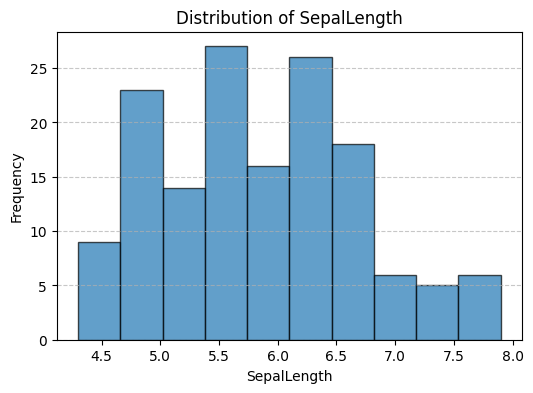

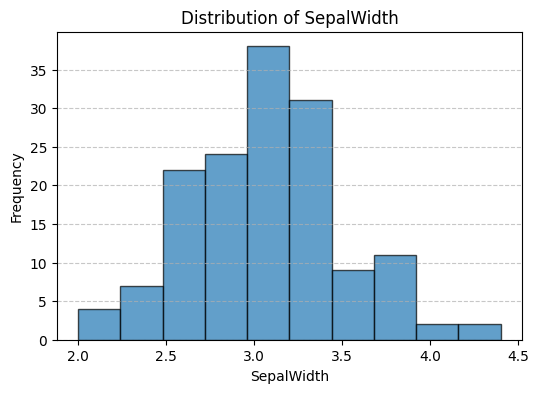

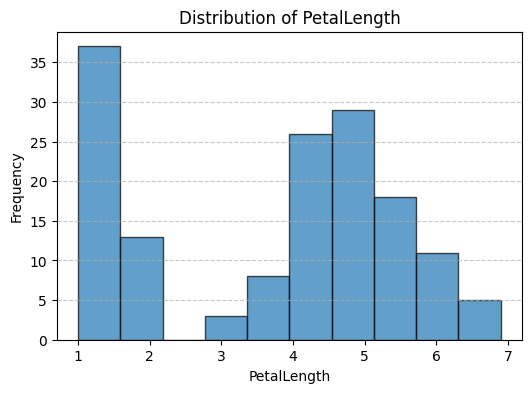

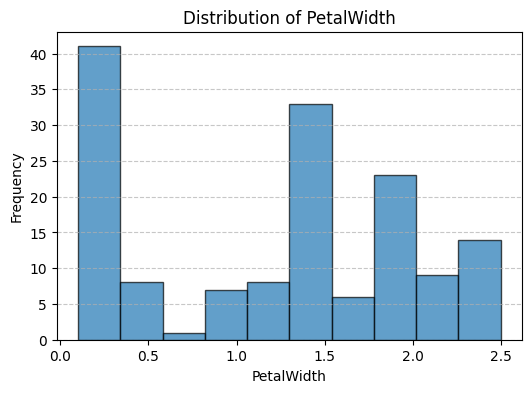

In [20]:
# normalization 전에 feature 분포 시각화 

features = ["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"]

for feature in features:
    plt.figure(figsize=(6, 4))
    plt.hist(df[feature], bins=10, edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [21]:
# Z-score normalization 진행

from sklearn.preprocessing import StandardScaler

SS = StandardScaler()
df[[col for col in df.columns if col != 'Name']] = SS.fit_transform(df[[col for col in df.columns if col != 'Name']])

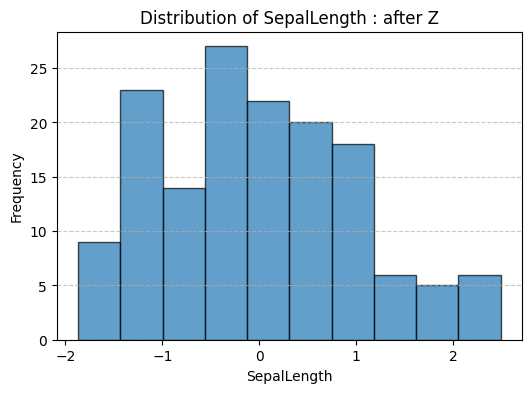

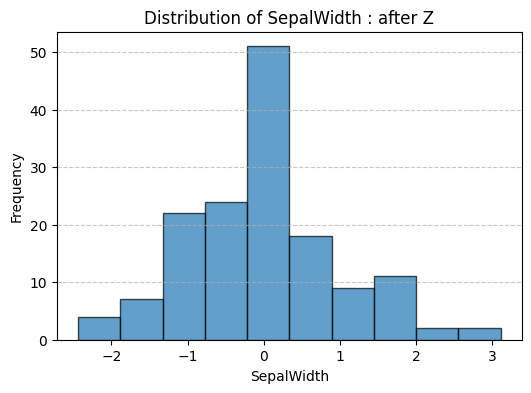

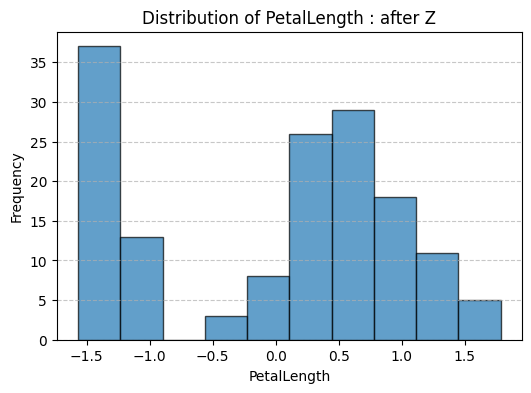

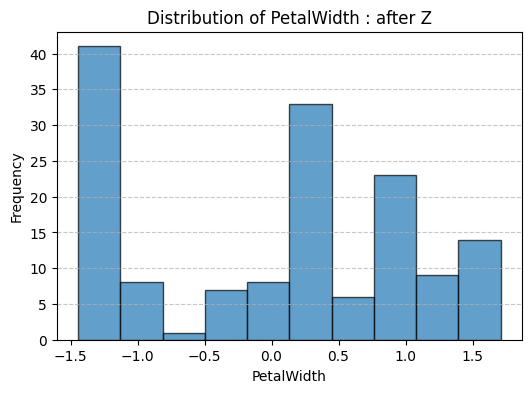

In [22]:
features = ["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"]

for feature in features:
    plt.figure(figsize=(6, 4))
    plt.hist(df[feature], bins=10, edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of {feature} : after Z")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

----

#### 2-3) data 분할 : train, test

- train : test = 8 : 2로 진행

In [23]:
# X, y로 분할

iris_X, iris_y = df[[col for col in df.columns if col != 'Name']], df['Name']

print (iris_X.shape, iris_y.shape)

(150, 4) (150,)


In [25]:
# X_train, y_train, X_test, y_test으로 train set, test set 각각 8 : 2로 split

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, 
                                                   test_size=0.2)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(120, 4) (120,)
(30, 4) (30,)


----


### 3. 각종 모델을 적용하여 classification
- SVM, random forest, decision tree, logistic regression, KNN 기법을 적용하여 classification
- 순서는 logistic regression, decision tree, random forest, SVM, KNN

#### 3-1) logistic regression

- logistic regression 모델을 사용하여 다중 분류를 진행한다.
- softmax 함수를 사용하여 feature 수만큼의 z값을 확률로 변환한다.
    - 직접 z값을 구하여 진행할 수 있으나, predict_proba 메소드를 사용하여 진행하도록 한다.
- hyperparameter인 max_iter 최적값을 도출한다.
    - 최적의 hyperparameter를 찾기 위해 그리드 서치 기법을 사용한다.
    - 그리드는 아래와 같이 정의한다
        - C : log scale로 10^-10 ~ 10^10 사이 20개의 수
        - max_iter : 1000, 2000, 3000, 4000, 5000

In [27]:
# logistic regression 모델 fit 및 train score, test score 출력
# 이때, max_iter 최적의 하이퍼파라미터를 찾기 위해 grid search 기법 사용

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 하이퍼파라미터 그리드 정의
param_grid = {
    'C': np.logspace(-10, 10, 20),
    'max_iter': [1000, 2000, 3000, 4000, 5000]
}

# Logistic Regression 모델 정의
lr = LogisticRegression()

# Grid Search 설정
grid_search = GridSearchCV(lr, param_grid, scoring='accuracy', n_jobs=-1)

# fit
grid_search.fit(X_train , y_train)

# 최적의 하이퍼파라미터 출력 및 score 출력
print(f'최적의 hyperparameter : {grid_search.best_params_}')
print(f'cross-validation score : {grid_search.best_score_}')

최적의 hyperparameter : {'C': 3.359818286283774, 'max_iter': 1000}
cross-validation score : 0.9583333333333334


PolynormialFeatures API를 도입하여 feature을 한번 늘려보고, 이를 통해서 score가 더 오르는지 확인해본다.

In [29]:
# PolynormialFeatures으로 특성 늘리기 -> 다시 스케일링

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
poly.fit(X_train)

X_train_poly = poly.transform (X_train)
X_test_poly = poly.transform (X_test)

print (f"shape | X_train_poly : {X_train_poly.shape}, X_test_poly : {X_test_poly.shape}")
print (f"poly | {poly.get_feature_names_out()}")

ss_transformer = StandardScaler()

ss_transformer.fit(X_train_poly)

X_train_poly = ss_transformer.transform(X_train_poly)
X_test_poly = ss_transformer.transform(X_test_poly)

shape | X_train_poly : (120, 15), X_test_poly : (30, 15)
poly | ['1' 'SepalLength' 'SepalWidth' 'PetalLength' 'PetalWidth' 'SepalLength^2'
 'SepalLength SepalWidth' 'SepalLength PetalLength'
 'SepalLength PetalWidth' 'SepalWidth^2' 'SepalWidth PetalLength'
 'SepalWidth PetalWidth' 'PetalLength^2' 'PetalLength PetalWidth'
 'PetalWidth^2']


다시 grid search를 진행해보자.

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

grid_search = GridSearchCV(lr, param_grid, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_poly, y_train)

print(f'최적의 hyperparameter : {grid_search.best_params_}')
print(f'cross-validation score : {grid_search.best_score_}')

최적의 hyperparameter : {'C': 428.13323987193957, 'max_iter': 1000}
cross-validation score : 0.95


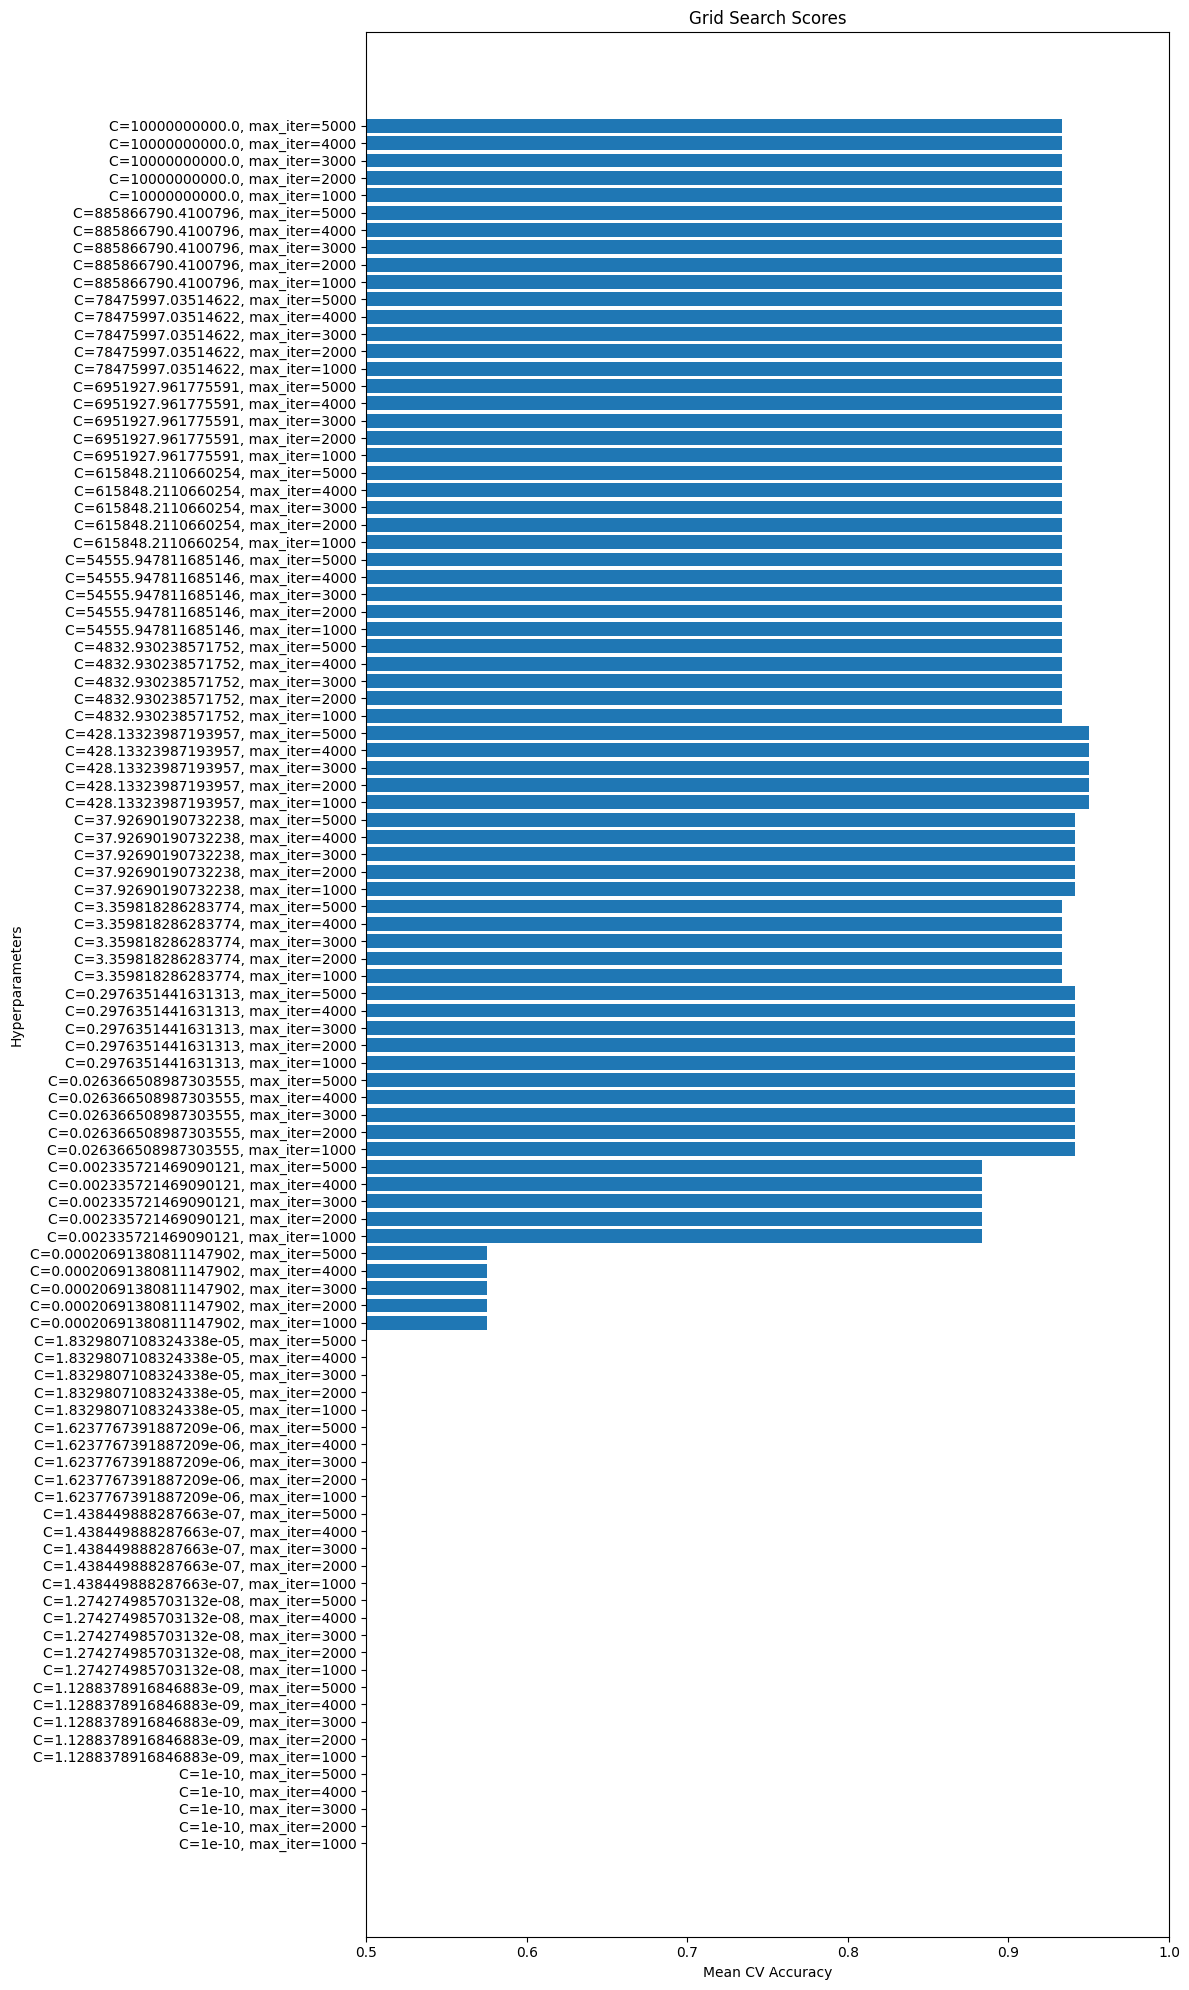

In [32]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = grid_search.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
C_values = [params[i]['C'] for i in range(len(params))]
max_iter_values = [params[i]['max_iter'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"C={C}, max_iter={max_iter}" for C, max_iter in zip(C_values, max_iter_values)])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Grid Search Scores')
plt.xlim([0.5, 1.0])  # x 축 범위 설정 (필요에 따라 조정 가능)
plt.tight_layout()
plt.show()

지금 보니깐, PolynormialFeatures를 적용하였을 때 가장 좋은 Accuracy를 가지는 Parameter는 C가 428, max_iter가 1000~5000 정도이다. 따라서 본 hyperparameter를 적용하여 best_model을 다시 갱신한다.

In [33]:
# fit, score

lr = LogisticRegression(C=428, max_iter=1000)
lr.fit (X_train, y_train)

lr_score = [lr.score(X_train, y_train), lr.score(X_test, y_test)]
print (f"train score, test score : {lr_score}")

train score, test score : [0.9916666666666667, 0.9666666666666667]


report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.89      0.94         9
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30

[[12  0  0]
 [ 0  8  1]
 [ 0  0  9]]


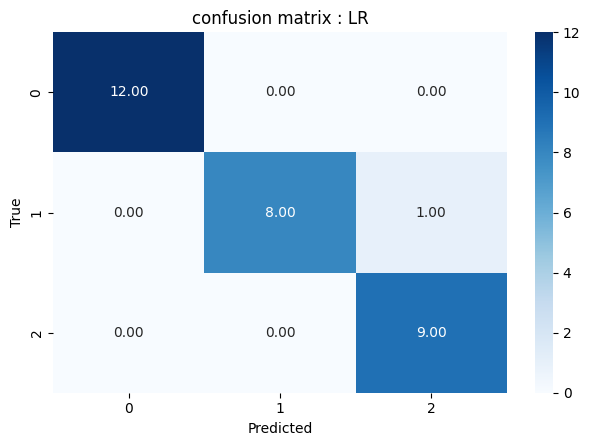

In [35]:
# report, confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

y_pred = lr.predict(X_test)
cm = confusion_matrix(y_pred, y_test)

print("report :\n", classification_report(y_pred, y_test))
print (cm)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('confusion matrix : LR')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


#### 3-2) decision tree

- decision tree 모델을 사용하여 다중 분류를 진행한다.
- hyperparameter인 max_depth, min_samples_split, min_samples_leaf 중 최적값을 도출한다.
    - 최적의 hyperparameter를 찾기 위해 랜덤 서치 기법을 사용한다.

In [36]:
# DT를 활용한 모델 fit 및 train score, test score 출력
# 이때, 랜덤 서치 기법을 사용하여 최적의 hyperparameter 도출

from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

param_grid = {'max_depth' : randint(20, 50), 
             'min_samples_split' : randint(2, 25), 
             'min_samples_leaf' : randint(1, 25)}

rs = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, 
                        n_iter=100, n_jobs=-1)
rs.fit (X_train, y_train)

print ("최적의 hypterparamter : ", rs.best_params_)
print (f'cross-validation score : {rs.best_score_}')

최적의 hypterparamter :  {'max_depth': 41, 'min_samples_leaf': 4, 'min_samples_split': 7}
cross-validation score : 0.9416666666666667


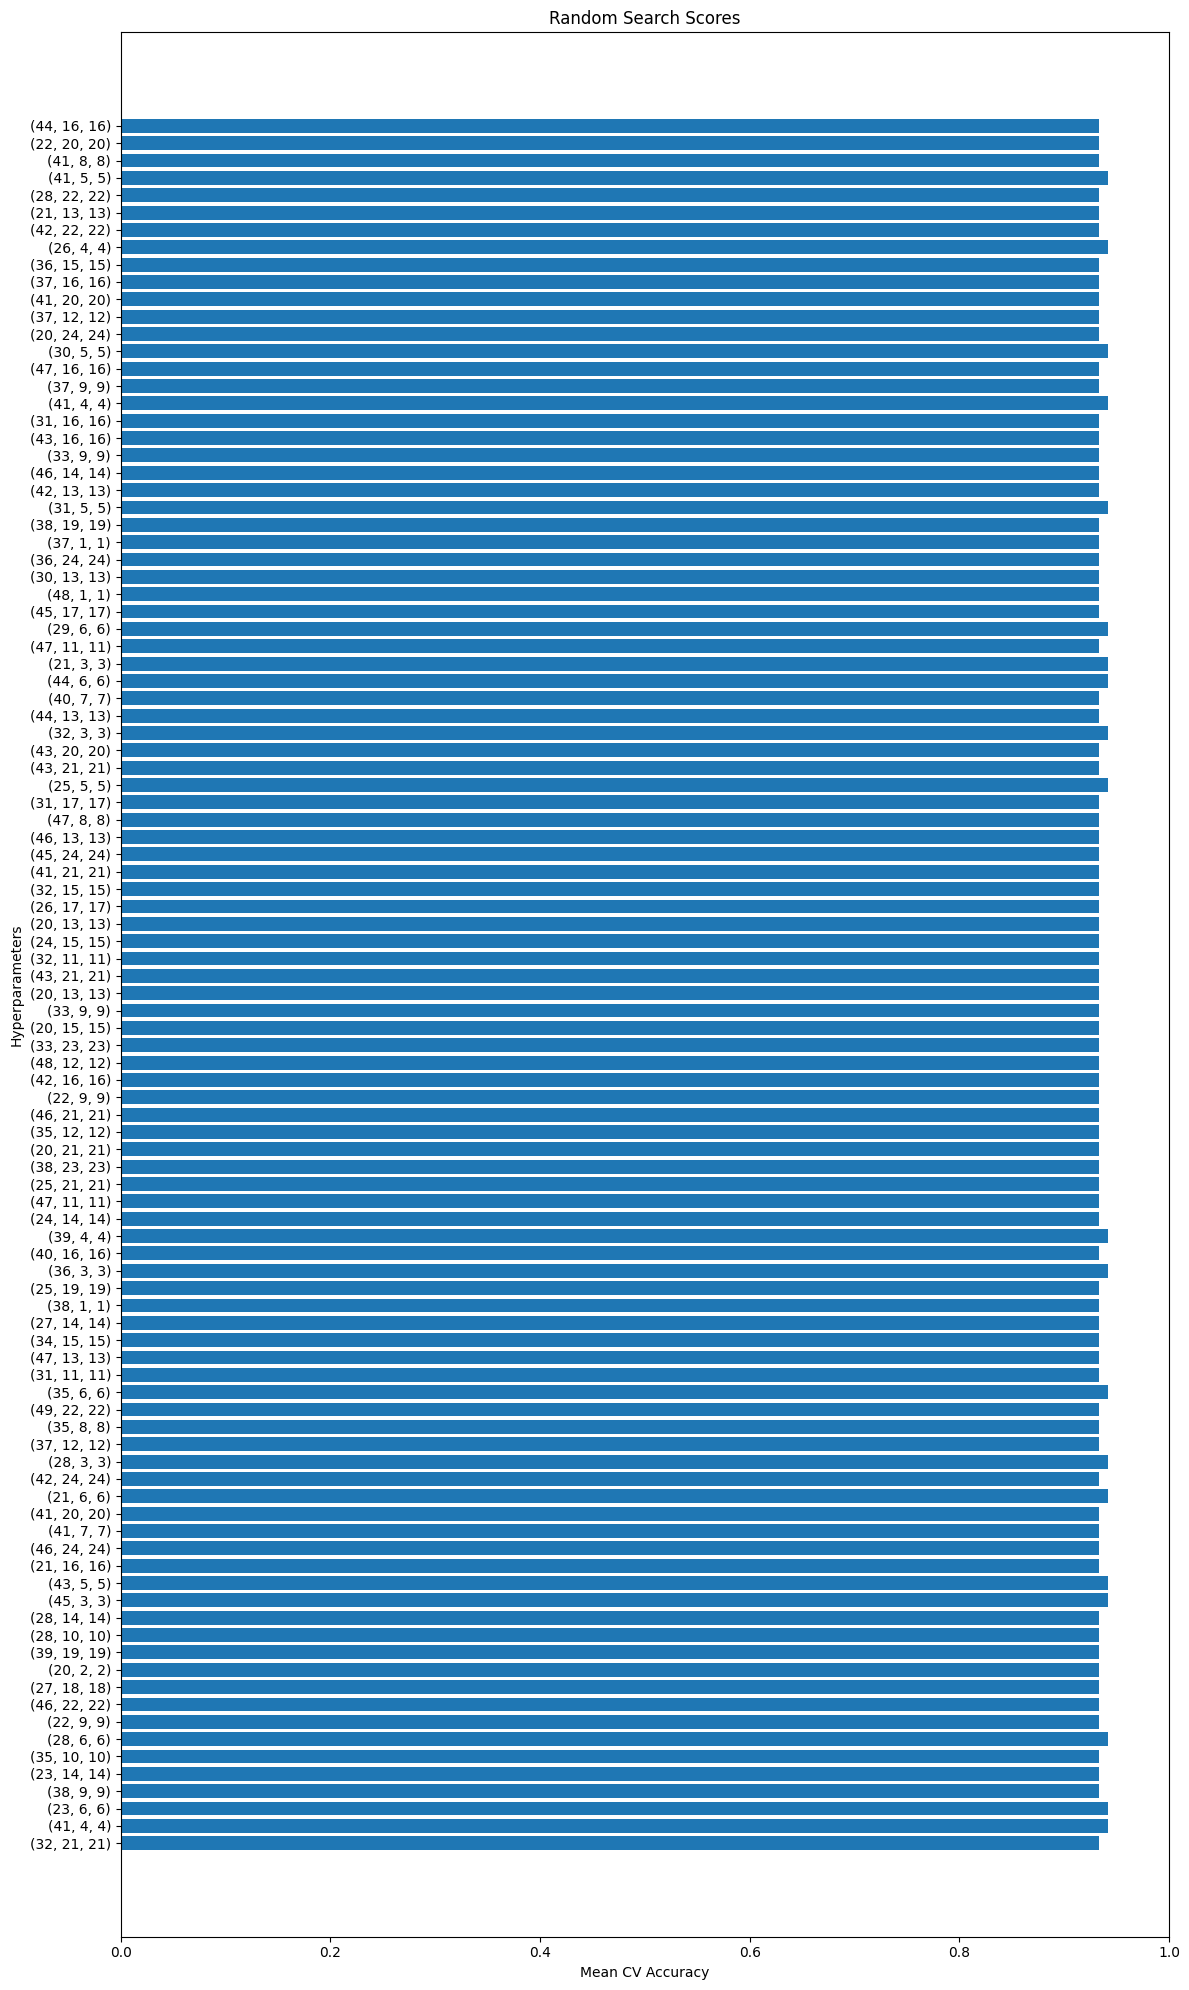

In [37]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = rs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
max_depth_values = [params[i]['max_depth'] for i in range(len(params))]
min_samples_split_values = [params[i]['min_samples_leaf'] for i in range(len(params))]
min_samples_leaf_values = [params[i]['min_samples_leaf'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"{com1, com2, com3}" for com1, com2, com3 in zip(max_depth_values, min_samples_split_values, min_samples_leaf_values)])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Random Search Scores')
plt.xlim((0, 1))
plt.tight_layout()
plt.show()

이도 역시 가장 좋은 Accuracy가 나오는 hyperparameter를 택한다. 'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 6로 설정하여 decision tree 할 시 가장 score가 크다는 것을 알 수 있다. 아래에 학습과 score를 진행한다.

In [39]:
# fit, score

dt = DecisionTreeClassifier(max_depth=44, min_samples_leaf=6, 
                           min_samples_split=6)
dt.fit (X_train, y_train)

dt_score = [dt.score(X_train, y_train), dt.score(X_test, y_test)]
print (f"train score, test score : {dt_score}")

train score, test score : [0.9583333333333334, 0.9666666666666667]


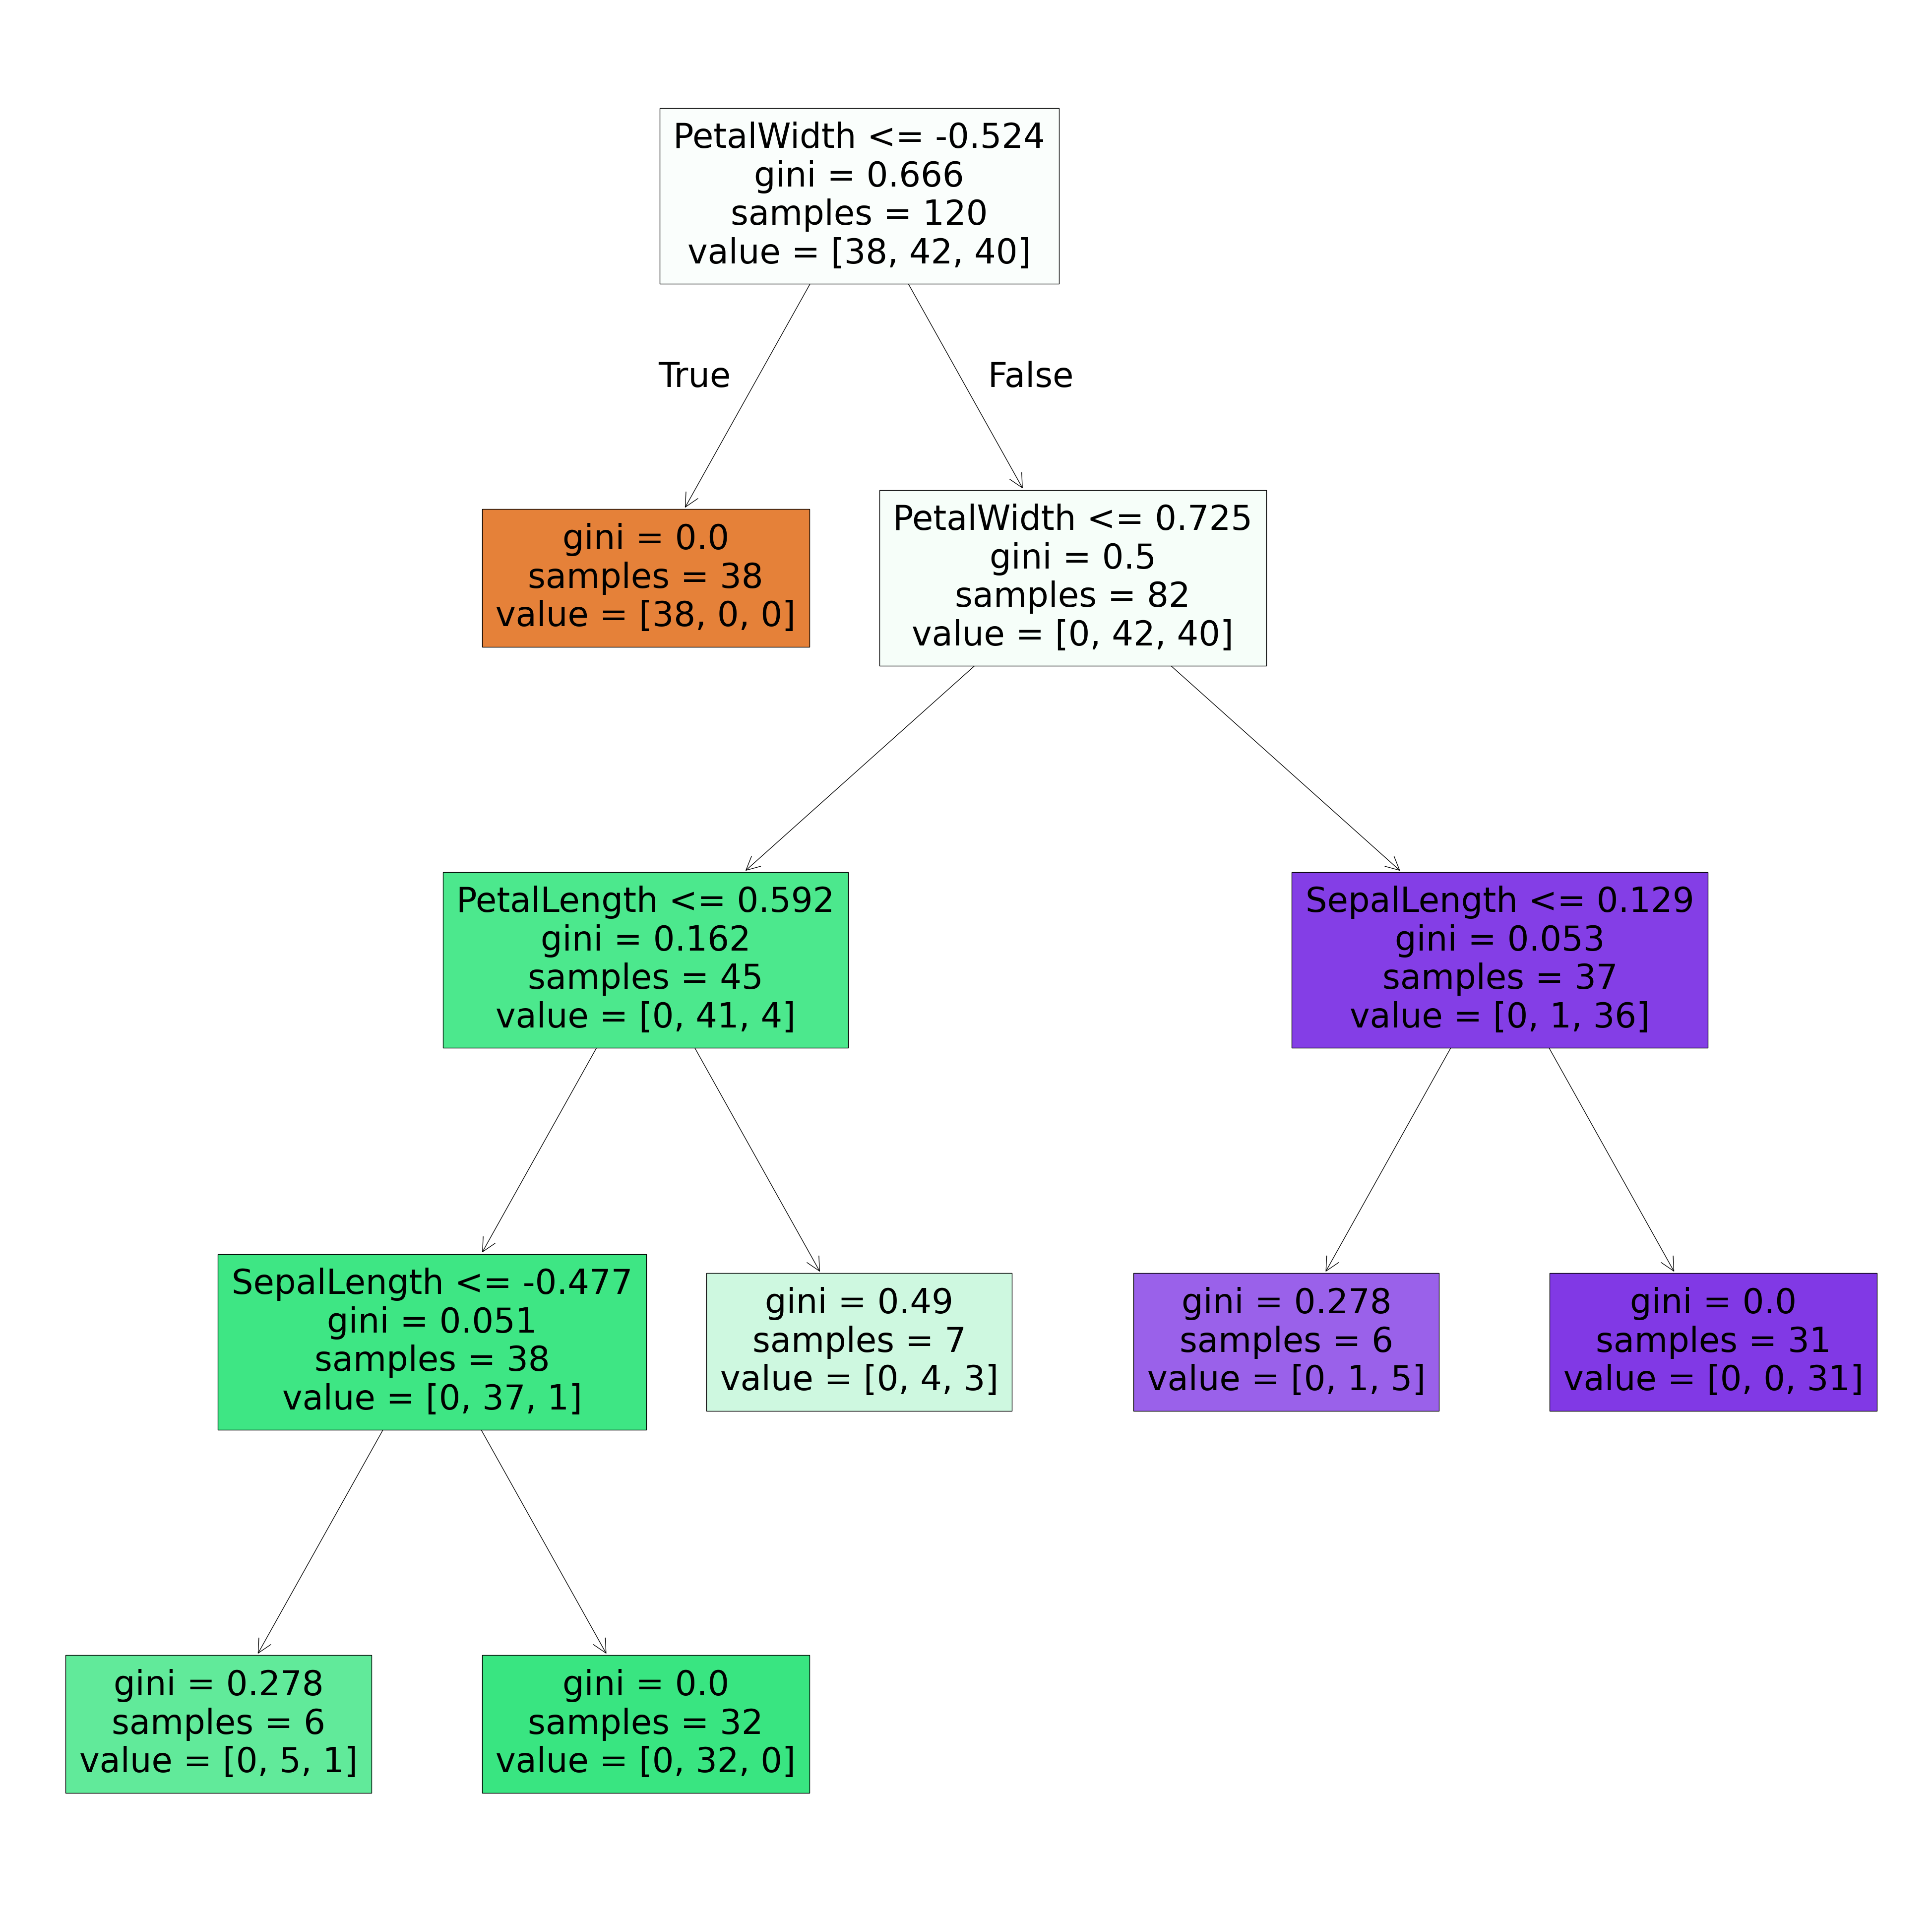

SepalLength의 중요도 :  0.00765300124103223
SepalWidth의 중요도 :  0.0
PetalLength의 중요도 :  0.026143387885306135
PetalWidth의 중요도 :  0.9662036108736616


In [42]:
# tree 시각화

from sklearn.tree import plot_tree

plt.figure (figsize=(50, 50))
plot_tree(dt, filled=True, feature_names=attr_list)
plt.show()

for i in range (len(dt.feature_importances_)) : 
    print (f"{attr_list[i]}의 중요도 : ", dt.feature_importances_[i])

**세상에! 역시나 이전 상관계수 heatmap에서 예상했던 것과 같이, SepalWidth는 iris 분류에 아예 영향을 미치지 않음을 확인 가능하다!** 소름이 끼쳐 눈물이 난다.

위 과정을 통하여 왼쪽에서는 양성 클래스, 오른쪽에서는 음성 클래스로 분리된 것을 확인 가능하고, 이를 통하여 가지치기가 명확히 수행되었다고 판단된다. 또한 각 feature의 중요도를 출력하여 그 중 PetalWidth가 본 tree의 질문 node 중 가장 중요도가 높은 것을 알 수 있다.

report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.89      0.94         9
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30

[[12  0  0]
 [ 0  8  1]
 [ 0  0  9]]


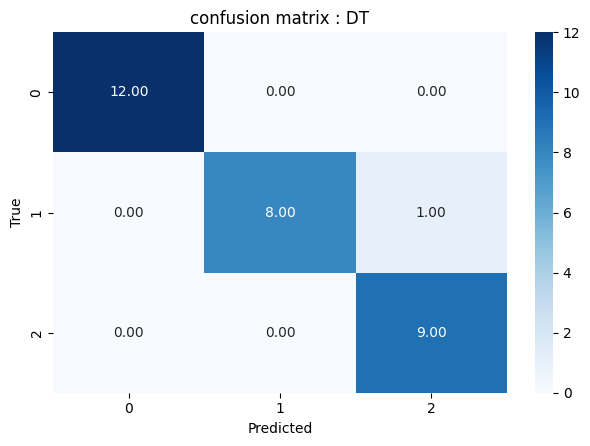

In [44]:
# report, confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

y_pred = dt.predict(X_test)
cm = confusion_matrix(y_pred, y_test)

print("report :\n", classification_report(y_pred, y_test))
print (cm)

# 첫 번째 heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('confusion matrix : DT')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

#### 3-3) random forest

In [46]:
# random forest를 통하여 classification
# fit, score

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)
rf.fit (X_train, y_train)

rf_score = [rf.score(X_train, y_train), rf.score(X_test, y_test)]
print (f"train score, test score : {rf_score}")

train score, test score : [1.0, 0.9666666666666667]


report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.89      0.94         9
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30

[[12  0  0]
 [ 0  8  1]
 [ 0  0  9]]


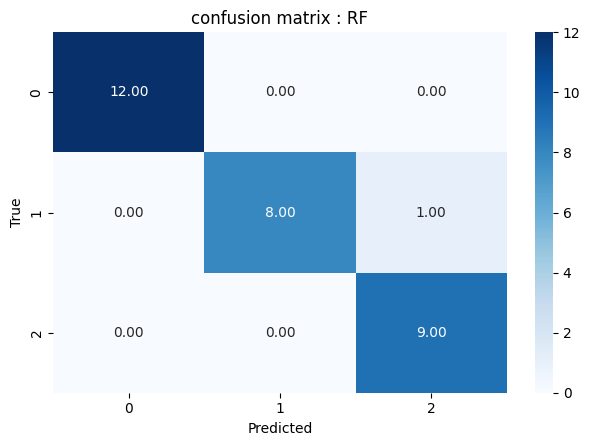

In [48]:
# report, confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_pred, y_test)

print("report :\n", classification_report(y_pred, y_test))
print (cm)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('confusion matrix : RF')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

#### 3-4) SVM
- linear kernel을 사용한다.
- classification report를 통하여 분류가 어떻게 진행되었는 지를 확인한다.

In [50]:
# fit, score

from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

svm_score = [svm.score(X_train, y_train), svm.score(X_test, y_test)]
print (f"train score, test score : {svm_score}")

train score, test score : [0.9833333333333333, 0.9666666666666667]


report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.89      0.94         9
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30

[[12  0  0]
 [ 0  8  1]
 [ 0  0  9]]


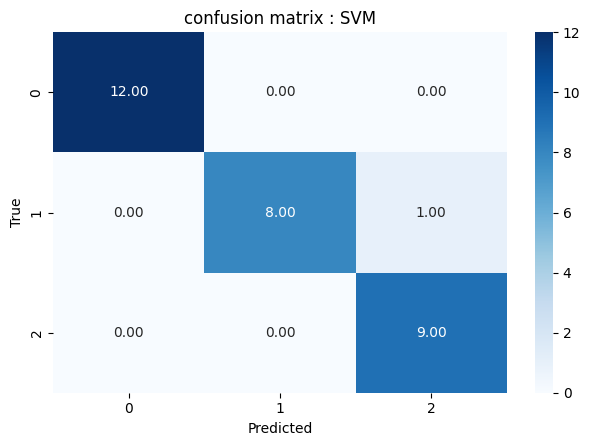

In [51]:
# report, confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test)
cm = confusion_matrix(y_pred, y_test)

print("report :\n", classification_report(y_pred, y_test))
print (cm)

# 첫 번째 heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('confusion matrix : SVM')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()



#### 3-5) KNN

- grid search를 도입하여 parameter tuning을 진행한다.

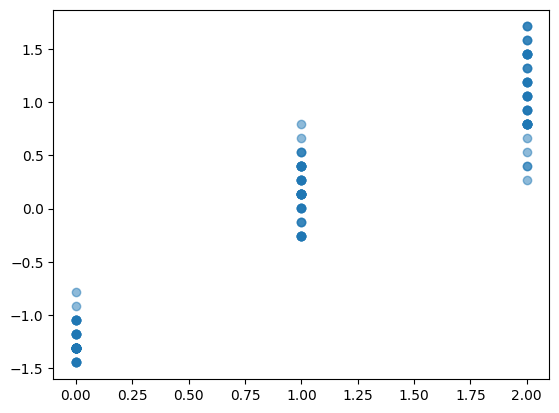

In [52]:
# scatter로 Name 시각화

plt.scatter (df['Name'], df['PetalWidth'], alpha=0.5)
plt.show()

**위를 보자. 역시 가장 corr가 높은 PetalWidth와 Name을 동시에 scatter로 시각화해보니, 한눈에 봐도 제대로 분류가 된다.**

- 위 figure에서 세로축이 PetalWidth, 가로축이 Name이다. 
    - 지금 보면 PetalWidth은 일전에 Z-score normalization을 진행하였기 때문에, -1~1 사이로 변환됨을 잘 알 수 있다.
        - 0에서의 PetalWidth의 구간은 -1.5~0.75 정도
        - 1에서의 PetalWidth의 구간은 -0.3~0.8
        - 2에서의 PetalWidth의 구간은 0.3~1.8

In [55]:
# fit, score

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan'] 
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("best parameter : ", grid_search.best_params_)
print("best acc :", grid_search.best_score_)

knn = grid_search.best_estimator_
test_score = knn.score(X_test, y_test)
print("test acc :", test_score)

svm_score = [svm.score(X_train, y_train), svm.score(X_test, y_test)]
print (f"train score, test score : {svm_score}")

best parameter :  {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
best acc : 0.9583333333333334
test acc : 0.9333333333333333
train score, test score : [0.9833333333333333, 0.9666666666666667]


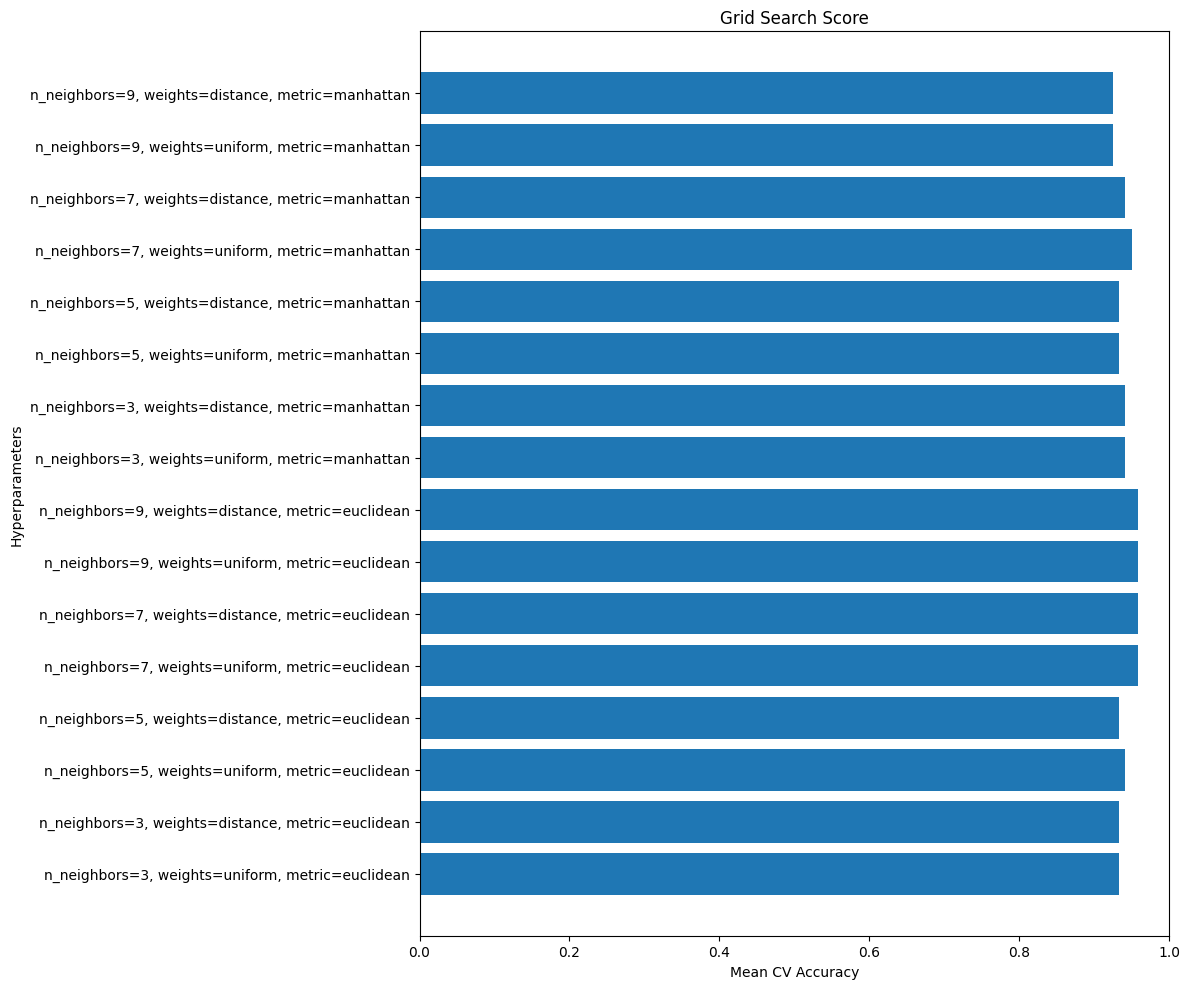

In [56]:
import matplotlib.pyplot as plt

results = grid_search.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

n_neighbors_values = [params[i]['n_neighbors'] for i in range(len(params))]
weights_values = [params[i]['weights'] for i in range(len(params))]
metric_values = [params[i]['metric'] for i in range(len(params))]

fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"n_neighbors={n}, weights={w}, metric={m}" for n, w, m in zip(n_neighbors_values, weights_values, metric_values)])

ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Grid Search Score')
plt.xlim((0, 1)) 
plt.tight_layout()
plt.show()


report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.80      0.89        10
           2       0.80      1.00      0.89         8

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.95      0.93      0.93        30

[[12  0  0]
 [ 0  8  2]
 [ 0  0  8]]


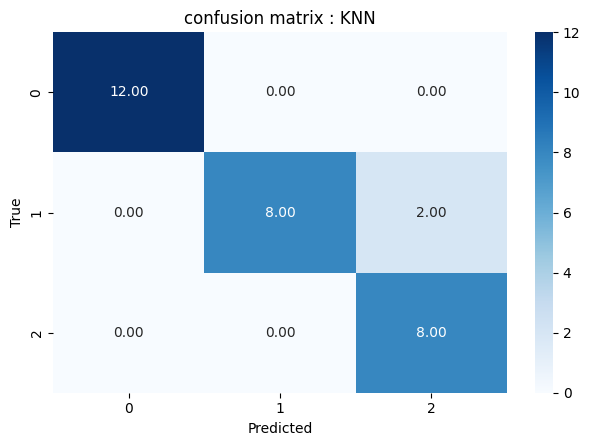

In [58]:
# report, confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

y_pred = knn.predict(X_test)
cm = confusion_matrix(y_pred, y_test)

print("report :\n", classification_report(y_pred, y_test))
print (cm)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('confusion matrix : KNN')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()